# ServiceX tutorial

Analysis code in HEP often involves several intermediate steps, including ntuplization and multiple skimmed subsets of data, and represents a significant investment of effort before it's possible to start making plots. The goal of ServiceX is to streamline this process by offering a high-performance pipeline directly from a complex starting data format like xAOD or DAOD to an analysis-friendly columnar format that can immediately be streamed by the analyzers.

In this tutorial we will go all the way from a dataset in xAOD format to an invariant mass plot. We will start from a 700GB MC dataset of ~ 2 million Z -> ee events distributed across 17 files in Rucio. From this we will read out 12 columns (the 4-momenta from the jets, electrons, and muons collections), which will be streamed to a message broker, where they can be read out by a user to produce plots.

As a first step, we install the necessary Python libraries:

In [1]:
import sys
!{sys.executable} -m pip install kafka-python lz4 pyarrow uproot minio confluent_kafka coffea

  Using cached https://files.pythonhosted.org/packages/aa/34/12f219f7f9e68e79a54874d26fbe974db1ab4efac4e6dae665b421df48f9/kafka_python-2.0.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/36/cc/81d45c7a6762cf4d8c969d26fb910059f039b4c5b7f9a9d8f4bdbab2b1b7/lz4-3.0.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/52/52/56b6cc41275cdc860c242febd1fae170bb6df461e4d0bdb6961dd6a32a9a/pyarrow-0.17.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/6d/fb/5d62be2dd24245eabdc7802b27ba784698134445ef07b71ecf0baf0993dd/uproot-3.11.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/aa/60/81f4a1dc2d320832840288d7ec88aa3e4ee495d8f1452b4c79d8bd67136b/minio-5.0.10-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/47/f5/6a7c2c3a2a880f8e6a3bbf71c3ba685a2761d96925e3c900fce11bfc4478/confluent_kafka-1.4.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cache

And import some useful modules:

In [2]:
import requests
from minio import Minio
import tempfile
import pyarrow.parquet as pq
import pyarrow as pa
import uproot
import uproot_methods
from confluent_kafka import Consumer, KafkaException
from coffea import hist
import matplotlib.pyplot as plt
import time

### Transform the data

ServiceX starts with the creation of a request. The user specifies the dataset to be transformed, along with the selection to be implemented (columns to be streamed out and any event-level filtering to be applied). For this tutorial we will take a Z -> ee MC dataset and read out the 4-momenta from three different object collections, which are then streamed to our broker for analysis.

We use a custom querying language to create the contents of the request in a format that can be read by the service. This language is very powerful and enables the user to specify a large number of features of the request, including computations to be performed (e.g. energy corrections for jets) or cuts to be used for in-place filtering. In our current example we're only interested in specifying the output columns. Specifically we ask for the following:

```
AntiKt4EMTopoJets.e
AntiKt4EMTopoJets.eta
AntiKt4EMTopoJets.phi
AntiKt4EMTopoJets.pt
Electrons.e
Electrons.eta
Electrons.phi
Electrons.pt
Muons.e
Muons.eta
Muons.phi
Muons.pt
```

The query that extracts these columns is reproduced below, but if you'd like to try out your own custom requests, this can be done with a small script located [here](https://github.com/mweinberg2718/useful-scripts/blob/master/xaod_qastle.py). Place the requested columns in a text file and call the file as an argument to the script to produce the associated query:

```
python xaod_qastle.py xaod_branches.txt
```

Starting from the columns shown above, we can send a request to ServiceX, which immediately returns a unique string that serves as the ID of the request. This request ID can be used to get updates on the progress of the system and to identify the data in the message broker.

In [3]:
# Configuration for ServiceX. These lines give the location of the service, the transformer to be
# used, the number of events per "chunk" in the broker, the number of workers assigned to transform
# the dataset, and the location of the output.
servicex_endpoint = 'http://marc-xaod-servicex-app.servicex:8000/servicex'
image_name = 'sslhep/servicex_xaod_cpp_transformer:MyConfigChunks'
chunk_size = 1000
n_workers = 10
broker_name = 'kafka-inc.servicex:9092'

# This defines the request itself. The first line gives the location of the dataset in Rucio, while
# the second specifies which columns to read out.
did_name = 'mc15_13TeV:mc15_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.merge.DAOD_STDM3.e3601_s2576_s2132_r6630_r6264_p2363_tid05630052_00'
selection_name = (
    "(call ResultTTree (call Select (call Select (call EventDataset (list 'localds:bogus')) (lambda (list e) (list (call (attr e 'Jets') 'AntiKt4EMTopoJets') (call (attr e 'Electrons') 'Electrons') (call (attr e 'Muons') 'Muons') ))) (lambda (list e) (list (call (attr (subscript e 0) 'Select') (lambda (list antikt4emtopojets) (call (attr antikt4emtopojets 'e')))) (call (attr (subscript e 0) 'Select') (lambda (list antikt4emtopojets) (call (attr antikt4emtopojets 'eta')))) (call (attr (subscript e 0) 'Select') (lambda (list antikt4emtopojets) (call (attr antikt4emtopojets 'phi')))) (call (attr (subscript e 0) 'Select') (lambda (list antikt4emtopojets) (call (attr antikt4emtopojets 'pt')))) (call (attr (subscript e 1) 'Select') (lambda (list electrons) (call (attr electrons 'e')))) (call (attr (subscript e 1) 'Select') (lambda (list electrons) (call (attr electrons 'eta')))) (call (attr (subscript e 1) 'Select') (lambda (list electrons) (call (attr electrons 'phi')))) (call (attr (subscript e 1) 'Select') (lambda (list electrons) (call (attr electrons 'pt')))) (call (attr (subscript e 2) 'Select') (lambda (list muons) (call (attr muons 'e')))) (call (attr (subscript e 2) 'Select') (lambda (list muons) (call (attr muons 'eta')))) (call (attr (subscript e 2) 'Select') (lambda (list muons) (call (attr muons 'phi')))) (call (attr (subscript e 2) 'Select') (lambda (list muons) (call (attr muons 'pt')))) ))) (list 'antikt4emtopojets_e' 'antikt4emtopojets_eta' 'antikt4emtopojets_phi' 'antikt4emtopojets_pt' 'electrons_e' 'electrons_eta' 'electrons_phi' 'electrons_pt' 'muons_e' 'muons_eta' 'muons_phi' 'muons_pt' ) 'forkme' 'dude.root')"
    )

# With these defined, we submit the request to ServiceX. Note the output will be stored in Arrow
# arrays in the Kafka message broker
response = requests.post(servicex_endpoint+"/transformation", json={
    "did": did_name,
    "selection": selection_name,
    "image": image_name,
    "chunk-size": chunk_size,
    "workers": n_workers,
    "result-destination": "kafka",
    "result-format": "arrow",
    "kafka":{
        "broker": broker_name
        }
    })

# Get the ID of the request
print("Request ID:", response.json()['request_id'])
request_id = response.json()["request_id"]
status_endpoint = servicex_endpoint+"/transformation/{}/status".format(request_id)

Request ID: 2e6a5a34-975e-4c10-a8ec-8d85120f6721


### Get updates on the transformation

Once the request is sent, we can get information back on the status of the request. Note that the transformer begins running as soon as the first files from the dataset are found within Rucio.

In [4]:
status = requests.get(status_endpoint).json()

print("Request ID:               ", status['request-id'])
print("Number of files processed:", status['files-processed'])
print("Number of files remaining:", status['files-remaining'])
if status['stats']:
    print("Maximum time per file:    ", status['stats']['max-time'], "sec")
    print("Average time per file:    ", status['stats']['avg-time'], "sec")
    print("Minimum time per file:    ", status['stats']['min-time'], "sec")
    print("Total time:               ", status['stats']['total-time'] / (n_workers * 60), "min")

Request ID:                2e6a5a34-975e-4c10-a8ec-8d85120f6721
Number of files processed: 17
Number of files remaining: 0
Maximum time per file:     344 sec
Average time per file:     85.88235294117646 sec
Minimum time per file:     17 sec
Total time:                2.433333333333333 min


### Read columns from message broker

Once you've started writing data to the Kafka message broker, you can start to read it out. Note that you don't have to wait until the transform is finished to start reading the data. We'll create a Kafka *consumer* to read the data; this can run concurrently with the producer that loads the data into Kafka.

In [5]:
from kafka import KafkaConsumer

# Here we specify the consumer group; to start reading data from the beginning, simply change this
# group_id string
consumer = KafkaConsumer(status['request-id'],
                         bootstrap_servers=['kafka-inc.servicex:9092'],
                         group_id='group_2',
                         consumer_timeout_ms=10000,
                         auto_offset_reset='earliest')

# Set up a histogram to hold the invariant mass
all_mass_hists = None
n_total_events = 0
n_total_messages = 0

You can start reading data out of Kafka as soon as the first record is put in. If more data shows up later, you can simply re-run the code snippet below. So long as the `group_id` doesn't change, the consumer will pick up where it left off. (Conversely, to run your code from the beginning, go back up and create a new consumer with a different `group_id` string.)

In [6]:
# We'll use AwkwardArray and Coffea tools to read out the Arrow arrays and create nice histograms
import awkward

# Read through each of the messages in the Kafka topic (defined by the request ID), select events
# with at least 2 electrons, and put their invariant mass into a histogram
tic = time.time()
for message in consumer:
    buffer = message.value
    reader = pa.ipc.open_stream(buffer)
    batches = [b for b in reader]
    
    n_total_messages += 1
    
    for batch in batches:
        arrays = awkward.fromarrow(batch)
        v_particles = uproot_methods.TLorentzVectorArray.from_ptetaphi(
            arrays['electrons_pt'], arrays['electrons_eta'],
            arrays['electrons_phi'], arrays['electrons_e']
            )
        v_particles = v_particles[v_particles.counts >= 2]
        diparticles = v_particles[:, 0] + v_particles[:, 1]
        
        mass_hist = hist.Hist('Counts', hist.Bin('mass', r'$m_{ee}$ (GeV)', 150, 0.0, 150.0))
        mass_hist.fill(mass=diparticles.mass/1000.0)
        
        if all_mass_hists:
            all_mass_hists = all_mass_hists.add(mass_hist)
        else:
            all_mass_hists = mass_hist

toc = time.time()
print("Total time to make histograms:", str(toc - tic), "sec")
print("Total messages:", n_total_messages)

Total time to make histograms: 29.891993761062622 sec
Total messages: 1994


We can now use standard matplotlib tools to plot the resulting histogram

/opt/conda/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


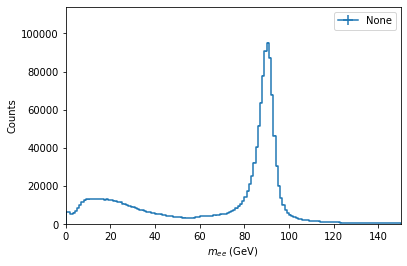

In [7]:
fig = hist.plot1d(all_mass_hists)
plt.show()